In [2]:
import subprocess
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
mapDict={0:["corners",4],
         1:["corners2",5],
         2:["loop-chain",7],
         3:["connector",6],
         4:["string",5],
         5:["tree",3],
         6:["tree2",17],
         7:["tunnel",4],
         8:["lak303d",1000],
         9:["random-32-32-10-2",485],
         10:["random-32-32-10",460],
         11:["maze-128-128-1",350],
         12:["room-64-64-8",1000],
         13:["w_woundedcoast",1000],
         14:["Berlin_1_256",1000],
         15:["brc202d",1000],
         16:["den312d",400],
         17:["maze-32-32-4",100],
         18:["maze-128-128-2",300],
         19:["orz900d",1000],
         20:["warehouse-20-40-10-2-1",1000],
         21:["warehouse-20-40-10-2-2",1000],
         22:["room-32-32-4"],
         23:["warehouse-10-20-10-2-1"]}

Candidates=[8,10,11,12,13,14,15,16,17,18,19,20,21]

result=subprocess.run('pwd', capture_output=True, text=True, check=True)
print(result.stdout)


/home/mugi/VSCODE/CPP/d-lacam3/evaluate



读取csv文件

In [10]:
import random
from tqdm import tqdm


def custom_sort(instance):
    # 分割字符串
    parts = instance.split('&&')
    # 获取名称部分和数值部分
    name_part = parts[0]
    value_part = int(parts[1])  # 将数值部分转换为整数
    return (name_part, value_part)  # 返回元组

csv_name="loss with SUO.csv"

df = pd.read_csv(csv_name)
# 提取特定列
columns = ['instance','total', 'n0', 'ub0', 'n4', 'ub4', 'average_ub0', 'average_ub4']
# 打印提取的 DataFrame
TieBreakers=['0','4']
selected=22
num=200
instance=mapDict[selected][0]+"&&"+str(num)
df=utils.check_and_add_instance(df,instance)
seeds_num=50
with tqdm(total=seeds_num, desc="Processing") as pbar:
    for i in range(seeds_num):
        seed=random.randint(0,100000000)
        # print(mapDict[selected][0])
        # print(num)
        # print(seed)
        df=utils.df_add_num(df,instance,'total',1)
        for tiebreaker in TieBreakers:
            # 构建命令
            compute = [
                '../build/main',
                '-i', f'../assets/{mapDict[selected][0]}.scen',
                '-m', f'../assets/{mapDict[selected][0]}.map',
                '-N', str(num),
                '-v', '1',
                '-t', '10',
                '--no-star',
                #'--no-scatter',
                '--tie-breaker',tiebreaker,
                '-s',str(seed),
            ]
            try:
                # 运行命令
                result_compute = subprocess.run(compute, capture_output=True, text=True, check=True)
                # 打印输出
                # print("标准输出:")
                # print(result_compute.stdout)
                # print("标准错误:")
                # print(result_compute.stderr)
                cost,lb,ub=utils.extract_total_cost(result_compute.stdout)
                if ub>=1:
                    df=utils.df_add_num(df,instance,'n'+tiebreaker,1)
                    df=utils.df_add_num(df,instance,'ub'+tiebreaker,round(ub,5))
                    average_ub=df.loc[df['instance'] == instance, 'ub'+tiebreaker]/df.loc[df['instance'] == instance, 'n'+tiebreaker]
                    df=utils.df_set_num(df,instance,'average_ub'+tiebreaker,round(average_ub,5))
                    df=df.sort_values(by='instance', key=lambda col: col.map(custom_sort))
                    df.reset_index(drop=True, inplace=True)
                    df.to_csv(csv_name, index=False)
                    pass
            except subprocess.CalledProcessError as e:
                print(f"命令执行失败: {e}")
                print(f"返回码: {e.returncode}")
                print(f"标准错误: {e.stderr}")
                break
        pbar.set_postfix(message=f"average_ub0:{df.loc[df['instance'] == instance, 'average_ub0'].values[0]},average_ub4:{df.loc[df['instance'] == instance, 'average_ub4'].values[0]}")
        #pbar.write(df.to_string())
        pbar.update(1)
print(df)


Processing: 100%|██████████| 50/50 [00:05<00:00,  8.92it/s, message=average_ub0:2.3100276000000006,average_ub4:2.2772240000000004]

            instance total  n0        ub0  n4       ub4 average_ub0  \
0  room-32-32-4&&200    50  50  115.50138  50  113.8612    2.310028   

  average_ub4  
0    2.277224  


绘图

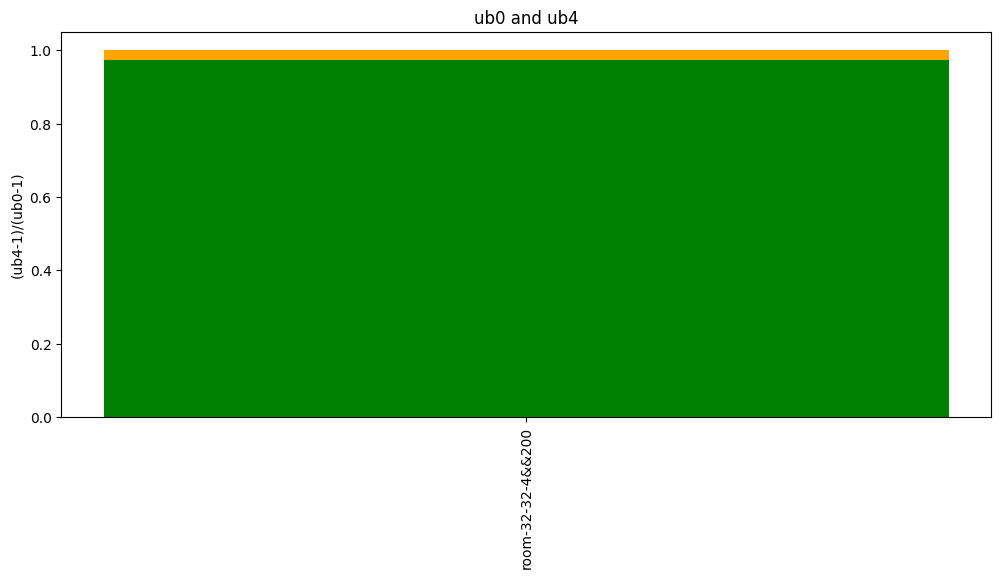

0.9749596115379552


In [11]:
df = pd.read_csv(csv_name)
# print(df)
# 设置柱状图的宽度
bar_width = 0.9
x = np.arange(len(df['instance']))
# 绘制叠加柱状图
plt.figure(figsize=(12,5))
plt.bar(x, 1, color='orange', label='average_ub0',width=bar_width)
reg_ub=(df['average_ub4']-1)/(df['average_ub0']-1)
plt.bar(x, reg_ub, color='green', label='average_ub4',width=bar_width)

# 添加标题和标签
plt.title('ub0 and ub4')
plt.ylabel('(ub4-1)/(ub0-1)')
#plt.ylim(bottom=1)
plt.xticks(x, df['instance'], rotation=90)
#plt.legend()

# 显示图形
plt.show()
print(sum(reg_ub)/len(reg_ub))